## GrubCut を用いた対話的画像切り出し

=================================================

最初に読んで下さい。  

　　実行すると画像ウィンドウが２つ開きます。１つは入力画像でもう一つは抽出結果の表示用です。

1. まず最初にマウスドラッグで対象を矩形で囲んでください。失敗した時は *R* で最初に戻ることができます。  
  1ステップだけ戻るような気のきいた機能はありません。
2. 確定したら、**Enter** キーを押して下さい。 GrabCutという手法による切り出しが実行されます。  切り出しには少し時間がかかりますので切り出しが完了するまで少し待って下さい。  
3. 切り出しがうまくいっていない場合は前景と背景のヒントを与えて**Enter** キー再度切り出しを実行する、  
という手順を満足がいく結果が得られるまで繰り返してください。

 - '0' - 背景領域を指定。
 - '1' - 前景領域を指定。
 - '2' - 背景の割合の多い領域であるという指定。
 - '3' - 前景の割合の多い領域であるという指定。
 - '9' - ９０度回転
 - 'R' - 初期化
 - 'S'  - 結果の保存
 - '+,-' - ブラシサイズを大きくする、小さくする
 

# メイン

In [ ]:
'''
 *  最初に矩形で対象を囲み、Enter を押して下さい。初期切り出しが実行されます。
 * 　０　を押すと削除指定モードになります。不要な部分をマウスで適当になぞり、Enter を押すと
 　　　指定した領域に接続する類似領域が削除されます。
 * もし必要な領域が削除されてしまったら、１を押してその領域を指定し、Enterを押します。
 * 何も指定せずに何度か Enter を押すとゴミが消えることがあります。
 
 - 0 - 背景領域を指定。
 - 1 - 前景領域を指定。
 - 2 - 背景の割合の多い領域であるという指定。
 - 3 - 前景の割合の多い領域であるという指定。
 - 9 - ９０度回転
 - R - 初期化
 - S  - 結果の保存
 - ± - ブラシサイズを大きくする、小さくする
 - Enter  - セグメンテーションの実行
'''
import numpy as np
import math
import cv2
import sys

import tkinter
import tkinter.filedialog
import tkinter.messagebox

%gui tk
root=tkinter.Tk()
root.withdraw()

BLUE = [255,0,0]        # rectangle color
RED = [0,0,255]         # PR BG
GREEN = [0,255,0]       # PR FG
MAGENTA = [255,0,255]    # sure BG
BLACK = [0,0,0]
WHITE = [255,255,255]   # sure FG
MINRECTSIZE = 400 # 領域指定とそうでない操作の切り分けのための矩形面積の下限

IMAGESIZE = 512  # 強制的に画像サイズをの数字以下に縮小する。

DRAW_BG = {'color' : MAGENTA, 'val' : 0}
DRAW_FG = {'color' : WHITE, 'val' : 1}
DRAW_PR_FG = {'color' : GREEN, 'val' : 3}
DRAW_PR_BG = {'color' : RED, 'val' : 2}

# filename = "horyou2c6k.jpg" 
# filename = "yumiko.png"

def main():
    global img,img2,orig,output,value,mask,shrinkN,filename, mouseCallBacker
    
    print( __doc__ )
    print("画像ファイルを選んで下さい")
    filename = readFilePath()
    
    #orig = getbase2img(cv2.imread(filename))  # 2のべき乗のサイズになるようパディング
    orig = cv2.imread(filename)
    img = orig.copy()    
    # img, shrinkN = shrink(img,size=512)   # 表示のため縦横いずれも512以下になるまで縮小
    img = resize(img, size=512)   # 表示のため縦横いずれも512以下になるまで縮小
    img2 = img.copy()                        # a copy of original image

    mask = np.zeros(img.shape[:2],np.uint8) # mask initialized to PR_BG
    output = np.zeros(img.shape,np.uint8)           # output image to be shown

    # input and output windows
    cv2.namedWindow('output')
    cv2.namedWindow('input')
    cv2.imshow('output',redmasked(output))
    cv2.imshow('input', img)

    mouseCallBacker = myMouse('input')
 
    cv2.moveWindow('input',img.shape[1],90)
    
    # print(" マウスの左ドラッグで抽出対象を囲って下さい \n")

    do_keyEventLoop()
    
    cv2.destroyAllWindows()
    cv2.waitKey(1) # jupyter notebook の場合、destroyWindowの後に waitKey しないと終了できなくなる    

# キーイベントの処理（これが事実上のメインループ）

In [2]:
def do_keyEventLoop():
    global img,img2,output,value,mask, rect,frame_or_mask, mouseCallBacker
    # キーイベントループ
    while(1):
    
        k = cv2.waitKey(1) # 1milisecond 入力を受け付ける　　0にすると無限に待ってしまう

        if k == 27:         # 終了は ESC
            break
            
        elif k == ord('0'): # 背景領域の指定
            # print(" 背景領域を指定 \n")
            value = DRAW_BG
        elif k == ord('1'): # 対象の指定
            # print(" 切り出し対象領域を指定 \n")
            value = DRAW_FG
        elif k == ord('2'): # 背景かも知れない領域の指定
            # print(" 背景かも知れない領域の指定 \n")
            value = DRAW_PR_BG
        elif k == ord('3'): # 前景かもしれない領域の指定
            # print(" 前景かもしれない領域の指定 \n")
            value = DRAW_PR_FG
            
        elif k == ord('+'):
            mouseCallBacker.thicknessUp()

        elif k == ord('-'):
            mouseCallBacker.thicknessDown()

            
        elif k == ord('9'): # 90度回転
            # print(" 回転します\n")
            img = img.transpose(1,0,2)[::-1,:,:]
            img2=img2.transpose(1,0,2)[::-1,:,:]
            mask=mask.transpose(1,0)[::-1,:]
            output=output.transpose(1,0,2)[::-1,:,:]
            width , height = img.shape[1], img.shape[0]
            rect= (rect[1],height-rect[0]-rect[2],rect[3],rect[2])
            cv2.imshow('output',redmasked(output))
            cv2.imshow('input',redmasked(output))
            
        elif k == ord('s'): # 画像の保存
            bar = np.zeros((img.shape[0],5,3),np.uint8)
            res = np.hstack((img2,bar,img,bar,output))
            
            print("抽出結果を保存するパスを選んで下さい（拡張子は不要）")
            savepath = saveFilePath()
            cv2.imwrite(savepath+".png",output)
            cv2.imwrite('grabcut_output.png',res)
            print("抽出結果は保存先:{}に、\n, それとは別に合成画像を grabcut_output.png に結果を保存しました.\n".format(savepath+".png"))
            
        elif k == ord('r'): # reset everything
            print("リセット \n")
            mouseCallBacker.init()
            img = img2 .copy()  # 画像を復元
            mask = np.zeros(img.shape[:2],np.uint8) # mask initialized to PR_BG
            output = np.zeros(img.shape,np.uint8)           # 出力画像用
            mouseCallBacker.thickness = 3
            
        elif k == 13 : #  Enter キー  セグメンテーションの実行
            # print("セグメンテーションの実行中。新しいメッセージが表示されるまでお待ち下さい。 \n")
            if (frame_or_mask == 0):         # grabcut with rect
                bgdmodel = np.zeros((1,65),np.float64)
                fgdmodel = np.zeros((1,65),np.float64)
                mask = mask.copy()
                cv2.grabCut(img2,mask,rect,bgdmodel,fgdmodel,1,cv2.GC_INIT_WITH_RECT)
                frame_or_mask = 1
            elif frame_or_mask == 1:         # grabcut with mask
                bgdmodel = np.zeros((1,65),np.float64)
                fgdmodel = np.zeros((1,65),np.float64)
                cv2.grabCut(img2,mask,rect,bgdmodel,fgdmodel,1,cv2.GC_INIT_WITH_MASK)
            # print(" 抽出がうまくいっていない場合は、手動でタッチアップしてから再度 N  を押して下さい。\n ０、２　背景領域の指定、１，３ 抽出対象領域の指定 \n")
            
        mask2 = np.where((mask==1) + (mask==3),255,0).astype('uint8')
        output = cv2.bitwise_and(img2,img2,mask=mask2)        
        

# マウスイベントを扱うクラス

In [3]:
class myMouse:
    def __init__(self, windowname):
        self.init()
        cv2.setMouseCallback(windowname, self.callBack, None)
        
    def init(self):
        global value,mask,framing,framed,drawing,rect,frame_or_mask
        # setting up flags
        rect = (0,0,1,1)
        drawing = False         # 描画モードオン
        framing = False           # 選択枠設定中
        framed = False       # 枠設定は完了している
        frame_or_mask = 100      # flag for selecting rect or mask mode
        value = DRAW_FG         # drawing initialized to FG
        self.thickness = 3           # ブラシサイズ
    
    def thicknessUp(self):
        self.thickness +=1
        
    def thicknessDown(self):
        if self.thickness > 0:
            self.thickness -=1
        
    def callBack(self, event, x, y, flags, param=None) :
        global img,img2,output,value,mask,framing,framed,drawing,rect,frame_or_mask
        # フレーム設定フェーズの処理
        if framed == False:
            if event == cv2.EVENT_LBUTTONDOWN:
                self.lx,self.ly = x,y
                framing = True # 矩形描画モードオン
            elif event == cv2.EVENT_MOUSEMOVE:  
                if framing == True :                      
                    img = img2.copy()
                    cv2.rectangle(img,(self.lx,self.ly),(x,y),BLUE,2)
                    rect = (min(self.lx,x),min(self.ly,y),abs(self.lx-x),abs(self.ly-y))  
            elif event == cv2.EVENT_LBUTTONUP:
                framing = False
                tmps = abs(self.lx-x)*abs(self.ly-y)  # 指定矩形の面積
                if tmps > MINRECTSIZE:
                    framed = True
                    cv2.rectangle(img,(self.lx,self.ly),(x,y),BLUE,2)
                    rect = (min(self.lx,x),min(self.ly,y),abs(self.lx-x),abs(self.ly-y))
                    frame_or_mask = 0
                    print(" Enterキーを押せば抽出を始めます。終わるまでしばらくお待ち下さい \n")
        else: # 枠指定がすでに済んでいる場合
            if drawing == True:
                cv2.circle(img,(x,y),self.thickness,value['color'],-1)
                cv2.circle(mask,(x,y),self.thickness,value['val'],-1)
                if event == cv2.EVENT_LBUTTONUP:
                    drawing = False
            else:
                if event == cv2.EVENT_LBUTTONDOWN:
                    drawing = True
                    
        cv2.imshow('output',redmasked(output))
        cv2.imshow('input',img)

# 画像サイズの調整プログラム

In [8]:
# 画像サイズの縦か横の大きい方が指定サイズになるようにリサイズする。
def resize(img, size=512):
    maxsize = np.max(np.array(img.shape[:2]))
    height = size*img.shape[0]//maxsize
    width = size*img.shape[1]//maxsize
    output = np.zeros((height+40, width+40,3),np.uint8)
    output[20:20+height,20:20+width]=cv2.resize(img,(width,height))
    return output

def redmasked(img):
    ones = np.ones(img.shape[:2],np.uint8)
    zeros = np.zeros(img.shape[:2],np.uint8)
    ret,img2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV)
    b,g,r = cv2.split(img2)
    red = cv2.bitwise_and(ones,b)
    red = cv2.bitwise_and(red,g)
    red = cv2.bitwise_and(red,r)
    red = cv2.merge((zeros,zeros,red*128))
    red = cv2.bitwise_or(red,img)
    return red

# ファイルオープンダイアログ

In [5]:
import tkinter
import tkinter.filedialog
import tkinter.messagebox
%gui tk
root=tkinter.Tk()
root.withdraw()

def readFilePath():
    fTyp=[('画像ファイルの選択',['jpg','png'])]
    filename=tkinter.filedialog.askopenfilename(filetypes=fTyp,initialdir = './pics')
    print("処理対象ファイル",filename)
    return filename

def saveFilePath():
    filename = tkinter.filedialog.asksaveasfilename()
    return filename

# メインプログラムの実行

In [10]:
main()


 *  最初に矩形で対象を囲み、Enter を押して下さい。初期切り出しが実行されます。
 * 　０　を押すと削除指定モードになります。不要な部分をマウスで適当になぞり、Enter を押すと
 　　　指定した領域に接続する類似領域が削除されます。
 * もし必要な領域が削除されてしまったら、１を押してその領域を指定し、Enterを押します。
 * 何も指定せずに何度か Enter を押すとゴミが消えることがあります。
 
 - 0 - 背景領域を指定。
 - 1 - 前景領域を指定。
 - 2 - 背景の割合の多い領域であるという指定。
 - 3 - 前景の割合の多い領域であるという指定。
 - 9 - ９０度回転
 - R - 初期化
 - S  - 結果の保存
 - ± - ブラシサイズを大きくする、小さくする
 - Enter  - セグメンテーションの実行

画像ファイルを選んで下さい
処理対象ファイル /Users/dan/Pictures/IMG_5357.JPG
 Enterキーを押せば抽出を始めます。終わるまでしばらくお待ち下さい 

抽出結果を保存するパスを選んで下さい（拡張子は不要）
抽出結果は保存先:/Users/dan/Desktop/Untitled.pngに、
, それとは別に合成画像を grabcut_output.png に結果を保存しました.



In [11]:
from PIL import Image

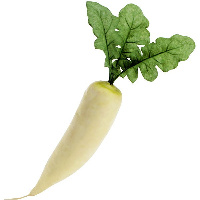

In [12]:
Image.open("pics/daikon2.jpg").resize((200,200))

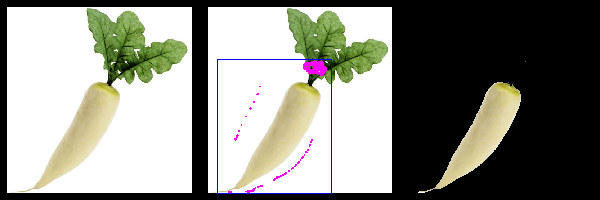

In [14]:
Image.open("pics/grabcut_output.png").resize((600,200))

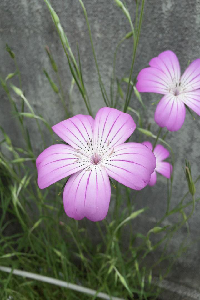

In [17]:
Image.open("pics/IMG_5357.JPG").resize((200,300))

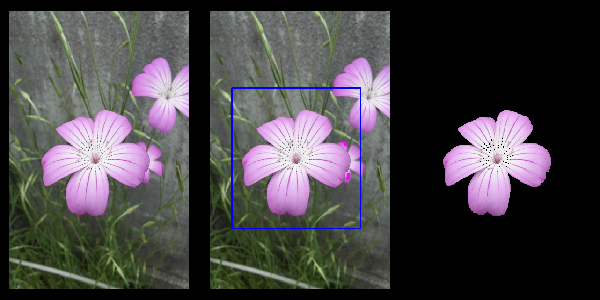

In [19]:
Image.open("grabcut.png").resize((600,300))

In [20]:
main()


 *  最初に矩形で対象を囲み、Enter を押して下さい。初期切り出しが実行されます。
 * 　０　を押すと削除指定モードになります。不要な部分をマウスで適当になぞり、Enter を押すと
 　　　指定した領域に接続する類似領域が削除されます。
 * もし必要な領域が削除されてしまったら、１を押してその領域を指定し、Enterを押します。
 * 何も指定せずに何度か Enter を押すとゴミが消えることがあります。
 
 - 0 - 背景領域を指定。
 - 1 - 前景領域を指定。
 - 2 - 背景の割合の多い領域であるという指定。
 - 3 - 前景の割合の多い領域であるという指定。
 - 9 - ９０度回転
 - R - 初期化
 - S  - 結果の保存
 - ± - ブラシサイズを大きくする、小さくする
 - Enter  - セグメンテーションの実行

画像ファイルを選んで下さい
処理対象ファイル /Users/dan/Pictures/IMG_5357.JPG
 Enterキーを押せば抽出を始めます。終わるまでしばらくお待ち下さい 

